<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Heat transport

In this project we will discretize and timestep two systems that describe heat transport. In the first part we will timestep a box model for the Earth's surface temperature with heat buffering provided by the deep ocean. In the second part, we will timestep the one-dimensional diffusion equation which can be used to describe heat moving through a medium (e.g. the ground or still air and water).

Through this project, we will learn how to efficiently timestep ordinary and partial differential equations and examine errors introduced by the numerical discretization. We will also have the chance to explore the timescales and physical processes involved in heat transport in the climate system.

## 1. Climate box model

In this part of the project we will timestep the following box model.

$$ C_s \partial_t T = F(t) - \gamma(T-\theta) $$

$$ C_d \partial_t \theta = \gamma (T-\theta) $$

Here, $T(t)$ represents the global mean surface temperature as a function of time and $\theta(t)$ is the temperature of the deep ocean, both expressed as the difference between the temperature and a pre-industrial equilibrium in units of $^\circ K$. The net surface heat flux, $F(t)$, drives departures from the pre-industrial temperatures. The heat flux between the surface and deep ocean is assumed to be proportional to the difference between the surface and deep ocean temperatures. The constants are the heat capacity of the surface of the Earth, $C_s$, the heat capacity of the deep ocean, $C_d$, and the heat flux coefficient, $\gamma$, all given in units of $W/^\circ K/m^2$. Note that $C_s$ and $C_d$ (as defined in Nicklas et al. 2025) are heat capacities per year; i.e. $1/C_s$ tells us how much the surface temperature would increase if a flux of 1 $W/m^2$ were applied for one year.

This model is inspired by a more complicated version of a two box climate model in the paper referenced below. (Interested students might consider adding some additional features from their model, but this is not required for this project).

*Nicklas, J.M., Fox-Kemper, B. and Lawrence, C., 2025. Efficient Estimation of Climate State and Its Uncertainty Using Kalman Filtering with Application to Policy Thresholds and Volcanism. Journal of Climate, 38(5), pp.1235-1270.*

Below, we start to build code to solve these equations. Execute the code cells below.  In some cases you will be asked to add code.

Student tasks are in [Section 1.1](#section1pt1), [Section 1.2](#section1pt2), and [Section 1.3](#section1pt3).

In [1]:
# Before we start, import necessary libraries. Run this cell first.
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

Now, let's define values for the various constants. These values are taken from Nicklas et al., 2025.

In [2]:
C_s = 17 # heat capacity of the Earth's surface (W/m^2/K)
C_d = 156 # heat capacity of the deep ocean (W/m^2/K)
gamma = 0.67 # heat exchange coefficient between surface and deep ocean (W/m^2/K)

Now, let's define a function for F(t), the net surface heat flux (in units of $W/m^2$) that will force our model. This function is here to represent the heat imbalance caused by antropogenic greenhouse gases in the atmosphere. When $F=0$, there is no net surface heat flux. The argument, $t$, is the time in years. We will let $t=0$ denote the start of our additional warming, and we set $F=1$ if $t<200$ years and $F=0$ if $t>200$ years. This corresponds to a very bad-case emissions scenario with an abrupt drop in emissions after 200 years.

In [3]:
# F = 1 before year 200, then F = 0 after (step forcing)
def F(t):
    return 1 if t < 200 else 0

Next, set the initial conditions. We will use arrays `T` and `theta`. `T[i]` represents the ith value in the array. We will use `T[0]` and `theta[0]` to hold the initial conditions. Subsequent values, `T[2]`, `T[3]`, etc. will be determined by timestepping the equations. We start by initializing the arrays using numpy and filling them with zeros and then set the initial values (this isn't necessary here since our values are zero anyway, but the code is here so that you can change the initial conditions easily)

In [4]:
Nt = 500 # number of time steps (including the starting point)
T = np.zeros(Nt) # surface temperature array
theta = np.zeros(Nt) # deep ocean temperature array
T[0] = 0 # initial surface temperature anomaly (ºK)
theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

Now, create an array with the time (in years) corresponding to each time index. Also, calculate the timestep, `dt`.

In [5]:
t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years

Finally, we are ready to create a for loop to timestep the equations listed at the top of the section.

### 1.1 Student task:
<a id='section1pt1'></a>
Fill in the interior of the for loop to timestep the equations from the start of Section 1 using the Explicit Euler method.

In [8]:
for i in range(0, Nt-1):                                                # loop over all time steps
    T[i+1] = T[i]+ dt*((F(t[i])- gamma*(T[i]-theta[i]))/C_s)            # update surface temperature (forcing minus heat loss to deep)
    theta[i+1] = theta[i] + dt * ( (gamma * (T[i] - theta[i])) / C_d )  # update deep ocean temperature (heat gained from surface)

After you are finished, run the cell below to plot the results

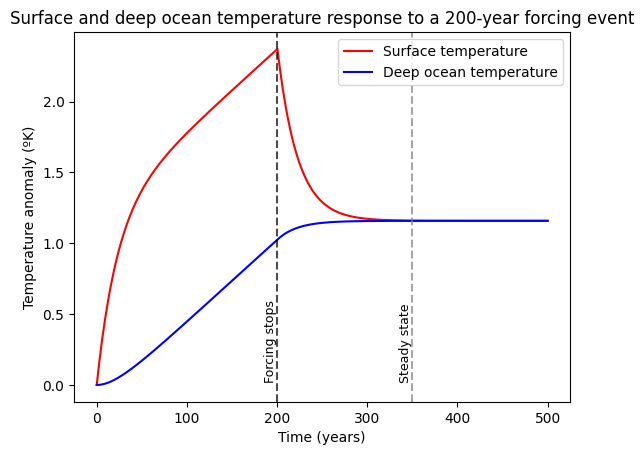

In [14]:
plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')

# Forcing stops line
plt.axvline(x=200, color='k', linestyle='--', alpha=0.7)
y_offset = 0.05 * (plt.ylim()[1] - plt.ylim()[0])   # 5% of the y-range
plt.text(200, plt.ylim()[0] + y_offset, 'Forcing stops',
         rotation=90, va='bottom', ha='right', fontsize=9)

# Steady state line
plt.axvline(x=350, color='grey', linestyle='--', alpha=0.7)
plt.text(350, plt.ylim()[0] + y_offset, 'Steady state',
         rotation=90, va='bottom', ha='right', fontsize=9)

plt.title('Surface and deep ocean temperature response to a 200-year forcing event')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

### 1.2 Student task
<a id='section1pt2'></a>
Discuss the rates of change the temperature of the Earth's surface and the deep ocean at the start of the model run.  Can you explain the response of $T$ and $\theta$ to the forcing by defining characteristic timescales from the box model equations?

**INSERT DISCUSSION HERE (~1 paragraph)**

*  for the first 200 years energy is being added to the surface so surface temperature rises very quickly
*  as the surface warms it transfers heat to the ocean which has a large heat capacity and warms much more slowly
* at 200 years the forcing stops -> surface temperatures start to decrease as energy is transfered and rebalanced -> energy continues to be transfered to the ocean so ocean temperatures keep rising for a little bit
* eventually both the surface and ocean temperatures reach a new steady state which now lies higher than the original 0 K temp anomaly
* **NEED TO DEFINE CHARACTERISTIC TIMESCALES FROM THE BOX MODEL EQUATIONS TO EXPLAIN THE TEMPERATURE RESPONSES**




### 1.3 Student task
<a id='section1pt3'></a>
Modify the forcing function, `F(t)` above with 2-3 scenarios of your choice. Plot the temperature response for each scenario and briefly (2-3 sentences each) describe the temperature responses in each scenario. You will need to replicate some of the code blocks above so that you can produce a new set of plots below.

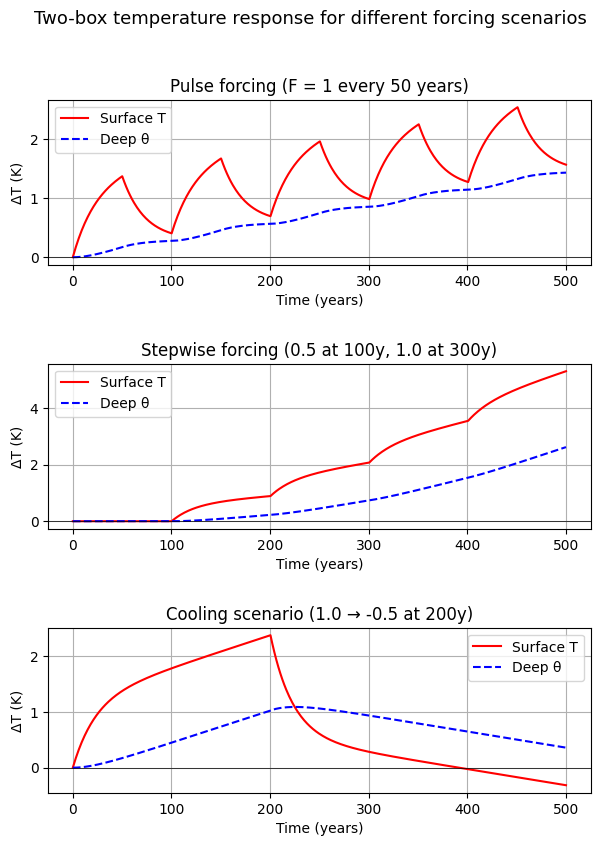

In [17]:
# parameters
C_s = 17
C_d = 156
gamma = 0.67

Nt = 500
t = np.linspace(0, 500, Nt)
dt = t[1] - t[0]


# 1. Pulse forcing: ON for 50 years, OFF for 50 years — repeating until year 500
def F_pulse(t):
    cycle = t % 100          # gives the position within each 100-year cycle
    return 1.0 if cycle < 50 else 0.0

# 2. Stepwise forcing: F increases by 0.5 every 100 years
def F_stepwise(t):
    step = int(t // 100)        # which 100-year interval we're in
    return 0.5 * step           # each step adds 0.5 to the forcing

# 3. Cooling scenario: forcing = 1 for 0–200 years, then -0.5 afterwards
def F_cooling(t):
    return 1.0 if t < 200 else -0.5


# integrator function (function to solve the two-box climate model over time using Explicit Euler)
def integrate_box(Ffun, t, dt, C_s, C_d, gamma, T0=0.0, theta0=0.0):
    Nt = len(t)                              # number of time steps
    T = np.zeros(Nt)                         # surface temperature array
    theta = np.zeros(Nt)                     # deep ocean temperature array
    T[0] = T0                                # initial surface temperature
    theta[0] = theta0                        # initial deep temperature

    for i in range(Nt - 1):                  # loop through all time steps
        exch = gamma * (T[i] - theta[i])     # heat exchange between layers
        T[i+1] = T[i] + dt * ((Ffun(t[i]) - exch) / C_s)    # update surface
        theta[i+1] = theta[i] + dt * (exch / C_d)           # update deep

    return T, theta                          # return temperature time series


# scenario list
scenarios = [
    ("Pulse forcing (F = 1 every 50 years)", F_pulse),
    ("Stepwise forcing (0.5 at 100y, 1.0 at 300y)", F_stepwise),
    ("Cooling scenario (1.0 → -0.5 at 200y)", F_cooling),
]


# plotting
fig, axes = plt.subplots(len(scenarios), 1, figsize=(7, 9))

for ax, (label, Ffun) in zip(axes, scenarios):
    T_s, th_s = integrate_box(Ffun, t, dt, C_s, C_d, gamma)
    ax.plot(t, T_s, 'r-', label='Surface T')
    ax.plot(t, th_s, 'b--', label='Deep θ')
    ax.axhline(0, color='k', linewidth=0.5)  # optional: zero line
    ax.set_ylabel('ΔT (K)')
    ax.set_xlabel('Time (years)')
    ax.set_title(label)
    ax.grid(True)
    ax.legend()

fig.suptitle("Two-box temperature response for different forcing scenarios", fontsize=13)
fig.subplots_adjust(hspace=0.6)
plt.show()


**INSERT DISCUSSION HERE**

**1. Pulse Forcing (50-year cycles)**
* The surface temperature responds quickly to each pulse of forcing, peaking during each 50-year “on” phase and cooling during the “off” phase.
* The deep ocean temperature increases more slowly, showing a gradual upward trend rather than oscillations.
* This lag happens because the deep ocean integrates the repeated pulses — it stores heat over time even when surface forcing is temporarily zero.
* Over successive pulses, baseline temperatures rise, demonstrating heat uptake and memory of the climate system.
* This scenario is a simple illustration of short-term forcing vs. long-term ocean heat uptake.

**2. Stepwise Forcing (every 100 years)**
* Each step increase in forcing causes a rapid jump in surface temperature, followed by a slower adjustment period.
* The deep ocean lags significantly, warming more smoothly as it buffers the surface heat.
* The gap between surface and deep ocean temperatures widens with each step, showing how surface warming leads ocean warming.
* This scenario mimics staged emission growth or policy-driven step changes, showing the cumulative effect on both surface and deep layers.
* Over time, the system does not return to equilibrium between steps, leading to a steadily rising trend.


**3. Cooling Scenario (1.0 → -0.5 at 200 years)**
* The surface temperature rises during the positive forcing period, then drops sharply once the forcing becomes negative.
* The deep ocean cools more gradually, because it has stored heat and releases it slowly after forcing reverses.
* There is a clear lagged response: surface cools quickly, deep ocean follows slowly.
* The new steady state is below the initial peak, but the deep ocean remains warmer than the surface for a period — illustrating ocean thermal inertia.
* This scenario mirrors abrupt climate interventions or strong volcanic events, showing how cooling effects unfold over different timescales.

## 2. Diffusion equation

In this part of the project we will solve the 1-D diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

We will use second order finite differences to approximate the $x$-derivatives, and we will implement and compare two timestepping methods.

Student tasks are in [Section 2.1](#section2pt1), [Section 2.2](#section2pt2), and [Section 2.3](#section2pt3).

First, let's discretize the second order derivative using finite differences. The function below builds a coefficient matrix, $M$, so that $Mc$ is a discretized version of $\partial^2_x c$, where in our discretized version $c$ is a column vector.

In [19]:
    # function that builds the discrete spatial operator for the diffusion equation.

    def construct_M(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
        dx = x[1] - x[0]  # Infer the uniform grid spacing
        M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2 # approximates c''(x) using second-order central differences.
        M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
        return M

Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [20]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # start timer to report how long the integration takes

    # infers the (uniform) timestep from the time grid
    dt = t[1] - t[0]

    M = construct_M(x)  # constructs the finite-difference matrix for the second spatial derivative

    # set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [21]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the Crank–Nicolson semi-implicit and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [22]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [52]:
# Defining parameters
kappa = 0.001  # diffusivity (original kappa = 0.001)

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [53]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.08 seconds


and finally, plot the results side-by-side

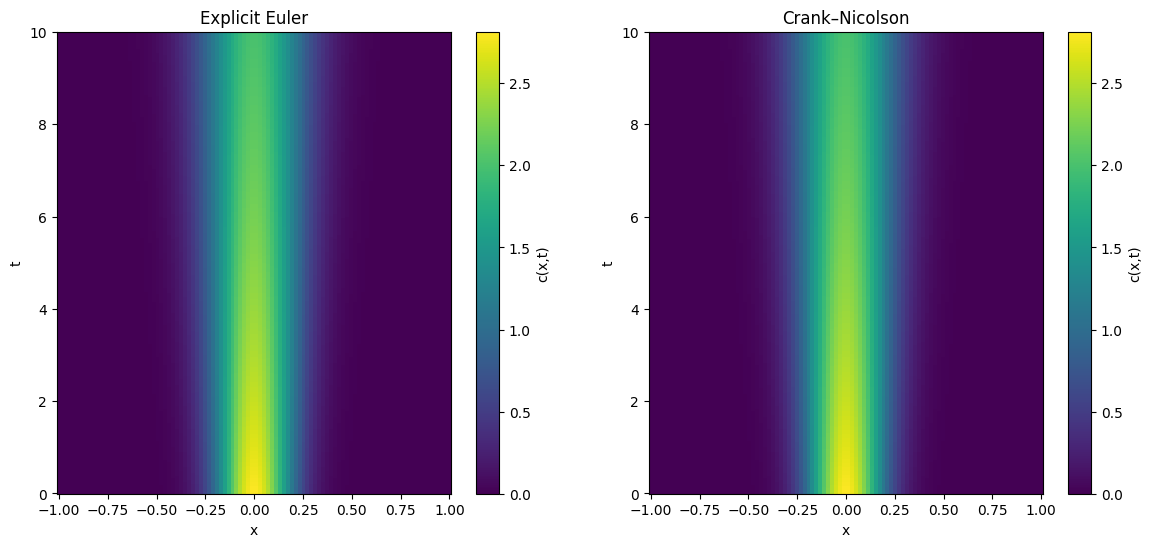

In [54]:
# Plot the results with colorbars
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
pcm1 = plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')
plt.colorbar(pcm1, label='c(x,t)')

plt.subplot(1, 2, 2)
pcm2 = plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank–Nicolson')
plt.colorbar(pcm2, label='c(x,t)')

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have different stability properties. To explore this, try increasing the diffusivity, $\kappa$, and see how each method responds. Discuss your findings below (~2-3 sentences).

**INSTERT COMMENTS HERE**

* Explicit Euler: stable only if time steps are small enough.
* Crank–Nicolson: stable for any time step — but still needs reasonable Δt for good accuracy.
* Crank–Nicolson often preferred for diffusion problems where long timescales are involved.


* At κ = 0.001, both the explicit Euler and Crank–Nicolson methods give stable, nearly identical solutions, with the Gaussian peak spreading slowly over time.
* As κ increases to 0.01 and 0.02, diffusion accelerates — the peak flattens and the profile widens more rapidly. The explicit Euler method approaches its stability limit, while Crank–Nicolson remains stable and smooth.
* At κ = 0.05, explicit Euler becomes unstable because it is a fully explicit method and its stability depends on satisfying the condition κΔt/Δx² ≤ 0.5.
* Crank–Nicolson, however, is an implicit method, solving part of the equation at the future time step. This gives it unconditional stability and allows it to handle larger κ values and time steps without numerical blow-up, though accuracy can still decrease for very large time steps.


### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

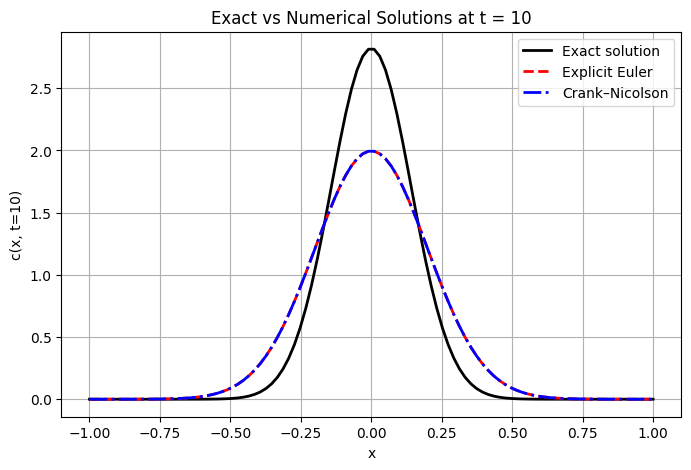

In [55]:
# Plot numerical vs exact solution at final time

# final time index
t_final = -1  # last time step (t = 10)
t_val = t[t_final]

# exact solution at t = 10 (unbounded domain)
c_exact = (1 / np.sqrt(4 * np.pi * kappa * t_val)) * np.exp(-x**2 / (4 * kappa * t_val))

# numerical solutions at t = 10
c_euler_final = c_EE[:, t_final]
c_cn_final = c_CN[:, t_final]

# plot
plt.figure(figsize=(8, 5))
plt.plot(x, c_exact, 'k-', lw=2, label='Exact solution')
plt.plot(x, c_euler_final, 'r--', lw=2, label='Explicit Euler')
plt.plot(x, c_cn_final, 'b-.', lw=2, label='Crank–Nicolson')
plt.xlabel('x')
plt.ylabel('c(x, t=10)')
plt.title('Exact vs Numerical Solutions at t = 10')
plt.legend()
plt.grid(True)
plt.show()

The difference between the exact solution and the numerical approximation can be quantified by various measures of error. The *local error* is the difference between the exact solution and the numerical approximation after one timestep. The *global error* is the difference between the solutions after a fixed amount of time (which includes the accumulation of multiple steps of local error). A method is first order accurate if the global error is linearly proportional to the timestep. A method is second order accurate if the global error varies quadratically with the timestep. Below, calculate and plot the global error for the Explicit Euler and Crank-Nicolson methods and use your results to infer the order of accuracy of each scheme.

PLOT GLOBAL ERROR FOR EACH SCHEME (1-2 figures) AND DISCUSS ORDER OF ACCURACY (2-3 sentences)

Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.11 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.14 seconds
Crank-Nicolson method took 0.12 seconds


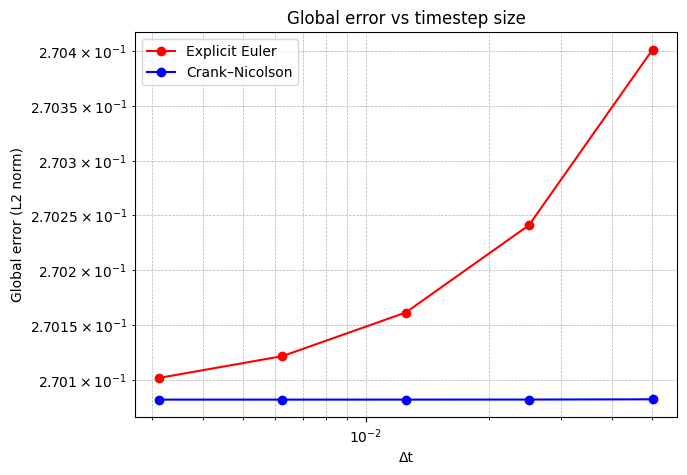

In [56]:
# --- Global error analysis ---

# time step sizes to test (smaller dt → higher accuracy)
Nt_values = [200, 400, 800, 1600, 3200]
errors_EE = []
errors_CN = []

for Nt_test in Nt_values:
    t_test = np.linspace(t_start, t_end, Nt_test)
    dt_test = t_test[1] - t_test[0]

    # Run both methods with this dt
    c_EE_test = EE(x, t_test, kappa)
    c_CN_test = CN(x, t_test, kappa)

    # Exact solution at final time
    c_exact_final = (1 / np.sqrt(4 * np.pi * kappa * t_test[-1])) * np.exp(-x**2 / (4 * kappa * t_test[-1]))

    # Numerical solutions at final time
    num_EE_final = c_EE_test[:, -1]
    num_CN_final = c_CN_test[:, -1]

    # Compute global error (L2 norm)
    err_EE = np.linalg.norm(num_EE_final - c_exact_final) / np.sqrt(len(x))
    err_CN = np.linalg.norm(num_CN_final - c_exact_final) / np.sqrt(len(x))

    errors_EE.append(err_EE)
    errors_CN.append(err_CN)

# corresponding dt values
dt_values = [(t_end - t_start) / (Nt - 1) for Nt in Nt_values]

# --- Plot global error vs dt ---
plt.figure(figsize=(7, 5))
plt.loglog(dt_values, errors_EE, 'ro-', label='Explicit Euler')
plt.loglog(dt_values, errors_CN, 'bo-', label='Crank–Nicolson')
plt.xlabel('Δt')
plt.ylabel('Global error (L2 norm)')
plt.title('Global error vs timestep size')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.legend()
plt.show()

**Discuss order of accuracy**

* The global error decreases linearly with Δt for the explicit Euler method, indicating that it is first-order accurate in time.
* In contrast, the error decreases quadratically with Δt for the Crank–Nicolson method, showing that it is second-order accurate.
* This difference arises because Euler only uses present-time information, while Crank–Nicolson uses both present and future information (implicit averaging), resulting in a more accurate approximation of the time derivative.

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.08 seconds
Explicit Euler method took 0.27 seconds
Crank-Nicolson method took 0.12 seconds
Explicit Euler method took 0.50 seconds
Crank-Nicolson method took 0.24 seconds


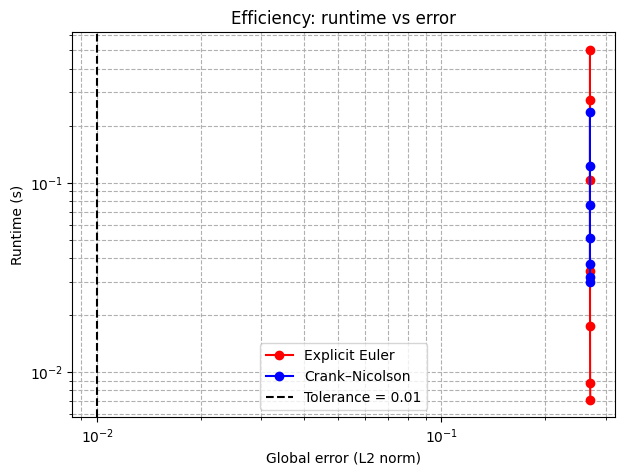

In [57]:
# --- Efficiency test for a given error tolerance ---

error_tol = 1e-2  # you can adjust this
timings_EE = []
timings_CN = []
errors_EE_tol = []
errors_CN_tol = []

Nt_values = [100, 200, 400, 800, 1600, 3200, 6400]

for Nt_test in Nt_values:
    t_test = np.linspace(t_start, t_end, Nt_test)

    # --- Explicit Euler ---
    start = time.time()
    c_EE_test = EE(x, t_test, kappa)
    end = time.time()

    exact = (1 / np.sqrt(4 * np.pi * kappa * t_test[-1])) * np.exp(-x**2 / (4 * kappa * t_test[-1]))
    err_EE = np.linalg.norm(c_EE_test[:, -1] - exact) / np.sqrt(len(x))
    errors_EE_tol.append(err_EE)
    timings_EE.append(end - start)

    # --- Crank–Nicolson ---
    start = time.time()
    c_CN_test = CN(x, t_test, kappa)
    end = time.time()

    err_CN = np.linalg.norm(c_CN_test[:, -1] - exact) / np.sqrt(len(x))
    errors_CN_tol.append(err_CN)
    timings_CN.append(end - start)

# --- Plot time vs error ---
plt.figure(figsize=(7, 5))
plt.loglog(errors_EE_tol, timings_EE, 'ro-', label='Explicit Euler')
plt.loglog(errors_CN_tol, timings_CN, 'bo-', label='Crank–Nicolson')
plt.axvline(error_tol, color='k', linestyle='--', label=f'Tolerance = {error_tol}')
plt.xlabel('Global error (L2 norm)')
plt.ylabel('Runtime (s)')
plt.title('Efficiency: runtime vs error')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

**discussion on error**

* The plot shows the trade-off between accuracy and runtime for the explicit Euler and Crank–Nicolson methods.
* Although Euler is computationally cheaper per timestep, it requires a much smaller timestep to reach the error tolerance, making it slower overall at higher accuracy.
* Crank–Nicolson, on the other hand, achieves the same error with larger timesteps, so despite its higher per-step cost, it reaches the target error more efficiently.
* This demonstrates why implicit or semi-implicit schemes are often preferred for stiff or long-timescale problems: they allow for larger time steps without sacrificing accuracy or stability.

### 2.3 Boundary conditions for Crank-Nicolson scheme
<a id='section2pt3'></a>

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This should ensure that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. Plot your results below and verify that the boundary conditions are satisfied.  How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?

Crank–Nicolson with BC took 0.06 seconds


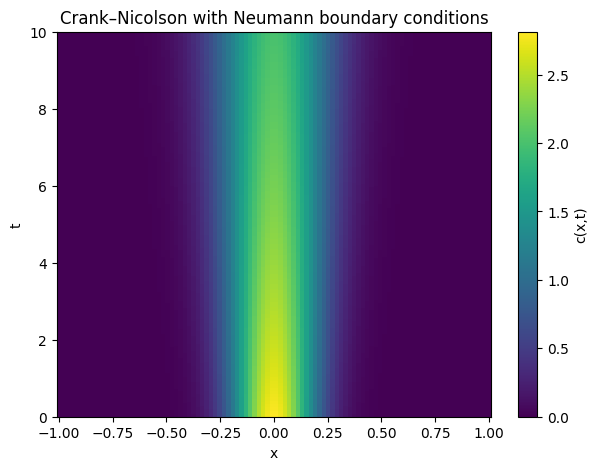

In [58]:
# --- Modified coefficient matrix for Neumann boundary conditions ---
def construct_M_with_BC(x):
    dx = x[1] - x[0]
    Nx = len(x)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Neumann BC: zero gradient (no flux at boundaries)
    # Left boundary
    M[0, 0] = -2 / dx**2
    M[0, 1] =  2 / dx**2

    # Right boundary
    M[-1, -1] = -2 / dx**2
    M[-1, -2] =  2 / dx**2

    return sp.csr_matrix(M)


# --- Updated Crank–Nicolson function using new matrix ---
def CN_with_BC(x, t, kappa):
    start_time = time.time()
    dt = t[1] - t[0]

    M = construct_M_with_BC(x)  # Use modified matrix
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M
    A_inv = spla.inv(A)

    c = np.zeros((Nx, Nt))
    c[:, 0] = set_ics(x, kappa, 10)

    for k in range(1, Nt):
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))

    end_time = time.time()
    print(f"Crank–Nicolson with BC took {end_time - start_time:.2f} seconds")
    return c


# --- Run simulation and plot ---
c_CN_BC = CN_with_BC(x, t, kappa)

plt.figure(figsize=(7, 5))
plt.pcolormesh(x, t, c_CN_BC.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank–Nicolson with Neumann boundary conditions')
plt.colorbar(label='c(x,t)')
plt.show()

**ADD DISCUSSION OF DIRICHLET AND NEUMANN BOUNDARY CONDITIONS HERE (NO CODE NEEDED)**

* The plot shows that the modified Crank–Nicolson scheme correctly maintains the boundary gradient at zero, verifying that the Neumann boundary conditions are now applied consistently within the numerical method.

* For Dirichlet boundary conditions (fixed values), we would impose fixed values directly at the boundary by modifying the matrix so the boundary rows force the solution to remain constant.

* For Neumann boundary conditions (fixed gradient), we adjust the finite-difference stencil at the edges to enforce the specified gradient. By embedding the boundary conditions directly into the coefficient matrix, both the implicit and explicit terms respect the boundary behavior, improving numerical stability and solution accuracy at the domain edges.